## Capstone Project 1: Modelling Cycle Hire Network
### Part 1: Data Wrangling

<b>The first part of the capstone project involves cleaning the data and adding appropriate features that will be useful in creating a model for the cycle hire scheme. Firstly, we need to retrieve the data from the AWS S3 file storage system. Here, we use the package, [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html?id=docs_gateway) to access the files. The function `find_bucket_obj()` retrieves the name of all the files stored in the S3 bucket and the funtion `s3_files_to_df()` reads the files into a string object and then, parses it into a dataframe.

In [1]:
import logging
import boto3
import re
import pandas as pd
import numpy as np
from datetime import datetime
from io import StringIO
from botocore.exceptions import ClientError
from aws_keys import ACCESS_KEY, SECRET_KEY


def find_bucket_obj(bucket_name, ACCESS_KEY, SECRET_KEY):
    """find all objects in AWS S3 bucket"""

    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
     aws_secret_access_key=SECRET_KEY)
    
    try:
        response = s3.list_objects_v2(Bucket=bucket_name)
    except ClientError as e:
    # AllAccessDisabled error == bucket not found
        logging.error(e)
        return None
    
    return response


def s3_files_to_df(bucket_name, key_names,ACCESS_KEY, SECRET_KEY):
    """appends S3 files into a dataframe"""
    
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
     aws_secret_access_key=SECRET_KEY)

    #quicker way to append files than appending straight into df
    cycle_data = StringIO()
    headers = StringIO()
    for i, key in enumerate(key_names):
        file = s3.get_object(Bucket=bucket_name, Key=key)
        tmp_str = file['Body'].read().decode('utf-8')
        cycle_data.write(tmp_str[112:])      
     
    headers = tmp_str[:112].split('\r\n')[0].split(',') #set column names
    data_type = {0:np.int64, 1:np.int64, 2:np.int64, 4:np.int64, 7:np.int64}
    dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")
    
    cycle_data.seek(0) #bring string pointer back to 0
    df = pd.read_csv(cycle_data, dtype=data_type, parse_dates=[3, 6], date_parser=dateparser, header=None,
                names=headers)
    
    return df


bucket_name = 'cycling.data.tfl.gov.uk'

response = find_bucket_obj(bucket_name, ACCESS_KEY, SECRET_KEY)
    
#find files in bucket that are of type csv and under usage-stats folder
key_names = (bucket_dict['Key'] for bucket_dict in response['Contents'] 
                        if re.search("\Ausage-stats.*19.csv", bucket_dict['Key']))

cycle_files_df = s3_files_to_df(bucket_name, key_names, ACCESS_KEY, SECRET_KEY)

<b>Now that we have downloaded the files, we first want to check if the dataset is clean and if not, use data wrangling to clean it such that we can use it in our model. The first things to check for are:</b>
<ul style="list-style-type:circle">
    <li>Null values</li>
  <li>Station names are matched with station IDs</li>
  <li>Station names are all valid (can be found in the dock locations file)</li>
  <li>Durations are all matched</li>
  <li>Time Outliers</li>
</ul>

<b>Depending on the outcome, we can either choose to remove certain data points completely or fill missing/incorrect values based on what information we have. 
</b>

In [26]:
cycle_files_df = cycle_files_df[cycle_files_df['Start Date'] >= datetime.strptime('01/06/19', '%d/%m/%y')]
cycle_df = cycle_files_df.sort_values(by=['Start Date'])
cycle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3032277 entries, 4066853 to 7005695
Data columns (total 9 columns):
Rental Id            int64
Duration             int64
Bike Id              int64
End Date             datetime64[ns]
EndStation Id        int64
EndStation Name      object
Start Date           datetime64[ns]
StartStation Id      int64
StartStation Name    object
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 231.3+ MB


In [27]:
diff = cycle_df['Start Date'].max() - cycle_df['Start Date'].min()
print('The dataset runs from ' + cycle_df['Start Date'].min().strftime('%d/%m/%Y') + ' to '
         + cycle_df['Start Date'].max().strftime('%d/%m/%Y') + ' which is ' + str(diff.days) + ' days.')


The dataset runs from 01/06/2019 to 27/08/2019 which is 87 days.


<b>The dataframe infromation tells us that all the columns are of the desired data type. This is because we have correctly parsed the dates within the `read_csv()` function. Moreover, we can see that there are no null values which is great! Let's now check if all the station names are valid and remove datapoints with invalid station name Then, we will check if the station names and IDs are matched<b>

In [28]:
# import file containing locaitons of all docks
location_df = pd.read_csv("data/cycle_dock_locations.csv")

# drop invalid station names
cycle_df = cycle_df.drop(cycle_df[~cycle_df['StartStation Id'].isin(location_df['id'])].index)
cycle_df = cycle_df.drop(cycle_df[~cycle_df['EndStation Id'].isin(location_df['id'])].index)

del_no = -len(cycle_df) + 3032277
print('We have removed {0:,} entries which is {1:.1f}% of entries'.format(del_no, (del_no/3379793)*100))

We have removed 51,960 entries which is 1.5% of entries


In [29]:
# check station names and IDs are matched
location_df = location_df.set_index('id')
df = cycle_df[['StartStation Id', 'StartStation Name']].merge(location_df['name'], 
                                how='left', left_on='StartStation Id', right_index=True)

map_names = df[df['StartStation Name'] != df['name']].drop_duplicates()
map_names

,StartStation Id,StartStation Name,name
4014729,553,"Regent's Row , Haggerston","Regent's Row , Haggerston"
4084466,832,"Ferndale Road, Brixton.","Ferndale Road, Brixton"
4224504,463,"Thurtle road, Haggerston","Thurtle Road, Haggerston"
4333723,725,"Thessaly Road North, Wandsworth Road","Walworth Square, Walworth"


<b>We see 4 names that have issues with matching the actual name. The first 3 are still correct information but get flagged due to character differences. The last one is a completely different entry which we will drop given we have no additional information on how to reconcile the difference. </b>

In [30]:
# map station names from location file to cycle hire data file and replace with correct name or remove if name non-existent
map_names = map_names[['StartStation Name', 'name']].set_index('StartStation Name')['name'].to_dict()
map_names['Thessaly Road North, Wandsworth Road'] = np.nan

cycle_df['StartStation Name'] = cycle_files_df['StartStation Name'].replace(map_names)
cycle_df = cycle_df.dropna()

df = cycle_df[['StartStation Id', 'StartStation Name']].merge(location_df['name'], 
                                how='left', left_on='StartStation Id', right_index=True)

if(df[df['StartStation Name'] != df['name']].empty):
    print('Success. All names match to ID')

Success. All names match to ID


<b>Now that we have sorted out the station names and IDs, we can check if the data has any outliers. This would be signified either by a ride with a very high duration or with a ride with no duration. We also need to make sure that the duration has been computed correctly.

In [31]:
print('{} rides have no duration'.format(len(cycle_df[cycle_df['Duration'] == 0])))

0 rides have no duration


In [32]:
#check if timedelta between start and end matches duration
check_duration = round((cycle_df['End Date'] - cycle_df['Start Date']).dt.total_seconds())
check_duration = check_duration.apply(lambda x: int(x))
print('Durations are all matched') if check_duration.equals(cycle_df['Duration']) else print("Durations don't match")

Durations are all matched


In [33]:
# print some statistics about duration
cycle_df['Duration(mins)'] = cycle_df['Duration'].apply(lambda x: x/60)
print('Avg time of rides was {:.0f} mins'.format(cycle_df['Duration(mins)'].mean()))
print('Max time of a ride was {:.0f} mins'.format(cycle_df['Duration(mins)'].max()))
print('Min time of a ride was {:.0f} min'.format(cycle_df['Duration(mins)'].min()))
print('Std deviation between rides was {:.0f} mins'.format(cycle_df['Duration(mins)'].std()))
print('{} rides over the period lasted more than one day'.format(cycle_df[cycle_df['Duration(mins)'] > (24*60)]['Rental Id'].count()))

Avg time of rides was 22 mins
Max time of a ride was 9024 mins
Min time of a ride was 1 min
Std deviation between rides was 68 mins
807 rides over the period lasted more than one day


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.xlim(right=50)
sns.distplot(cycle_df['Duration(mins)'], bins=1000)

plt.subplot(122)
plt.ylim(top=20)
sns.boxplot(y='Duration', data=cycle_df.groupby('Duration(mins)').count())

plt.show()

<Figure size 1200x300 with 2 Axes>

<b>There are quite a few rides that lasted over a day with the longest one being almost 6 days. This is most likely a result of forgetting to return the bikes or forgetting to dock them regularly throughout the trip. We will leave these outliers in the dataset as this affects the availability of bike at dock stations. It's also obvious from the boxplots that the most ride durations are concentrated below 10 minutes.</b>

<b>Now that we have filtered out unwanted rows, let's clean up the dataset by removing unwanted rows and reorganizing the columns.</b>

In [35]:
new_cols = ['Start Date', 'StartStation Name', 'End Date', 'EndStation Name', 'Duration(mins)',
               'Bike Id', 'StartStation Id', 'EndStation Id']
cycle_df_clean = cycle_df.drop(columns=['Rental Id', 'Duration'])
cycle_df_clean = cycle_df_clean[new_cols].reset_index(drop=True)
cycle_df_clean.head()

,Start Date,StartStation Name,End Date,EndStation Name,Duration(mins),Bike Id,StartStation Id,EndStation Id
0,2019-06-01,"Westminster University, Marylebone",2019-06-01 00:07:00,"St. John's Wood Church, The Regent's Park",7.0,13485,257,247
1,2019-06-01,"Upcerne Road, West Chelsea",2019-06-01 00:01:00,"Upcerne Road, West Chelsea",1.0,14376,745,745
2,2019-06-01,"Mile End Stadium, Mile End",2019-06-01 00:19:00,"Mile End Park Leisure Centre, Mile End",19.0,10693,712,763
3,2019-06-01,"Bethnal Green Road, Shoreditch",2019-06-01 00:10:00,"Curlew Street, Shad Thames",10.0,7390,132,298
4,2019-06-01,"Mile End Stadium, Mile End",2019-06-01 00:19:00,"Mile End Park Leisure Centre, Mile End",19.0,11332,712,763


<b>The second stage of data wrangling is to improve the usefulness of the data. We can add more features to our dataset that might be helpful in modelling demand and availability. The obvious factors in hiring a bike are:

<ul style="list-style-type:circle">
   <li>Type of day</li>
  <li>Weather</li>
</ul>


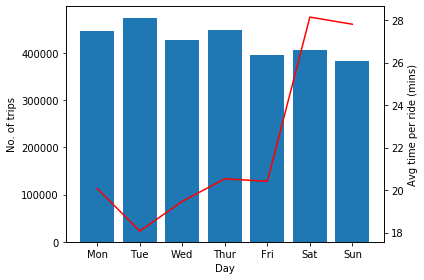

In [36]:
def plot_trip_data(x, y1, y2, xlabel, ylabel='No. of trips'):
    """plots count and mean data for trips"""
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.bar(x, y1)

    ax2 = ax1.twinx()

    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('Avg time per ride (mins)')
    ax2.plot(x, y2,
             color = 'red')

    fig.tight_layout() 
    plt.show()
    

#plotting number of rides and average time of rides on each weekday 
cycle_df_clean['Day'] = cycle_df_clean['Start Date'].dt.weekday    
group_by_day = cycle_df_clean.groupby('Day')
day_index = ['Mon','Tue','Wed', 'Thur', 'Fri', 'Sat', 'Sun']
plot_trip_data(day_index, group_by_day.count()['Duration(mins)'], 
               group_by_day.mean()['Duration(mins)'], 'Day')

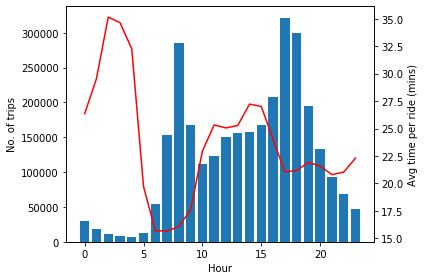

In [37]:
#plotting number of rides and average time of rides for each hour of day
cycle_df_clean['hour'] = cycle_df_clean['Start Date'].dt.hour
groupby_time = cycle_df_clean.groupby('hour')
time_index = groupby_time.sum().index

plot_trip_data(time_index, groupby_time.count()['Duration(mins)'], 
               groupby_time.mean()['Duration(mins)'], 'Hour')

<b>It is clear that there is high demand for bikes druing the weekend as opposed to a workday. We can add an additional feature that identifies if the day is a holiday(weekend/public holiday) or a workday. We use the package [`holidays`](https://pypi.org/project/holidays/) to get the holidays within the time period.

In [38]:
import holidays

# find holidays in England that match data time window
ph = list(filter(lambda x: cycle_df_clean.iloc[0]['Start Date'] <= x <= cycle_df_clean.iloc[-1]['Start Date'],  
                 holidays.England(years=2019).keys()))

In [39]:
def set_day_code(row, public_hols):
    
    if row['Start Date'].date() in public_hols:
        return 'PH'
    elif row['Day'] in [6, 7]:
        return 'WD'
    else:
        return 'W'

    
# set codes for days based on type of day (weekday=W, weekend=WD, public holiday=PH)
cycle_df_clean['day_code'] = cycle_df_clean.apply(lambda x: set_day_code(x, ph), axis=1)

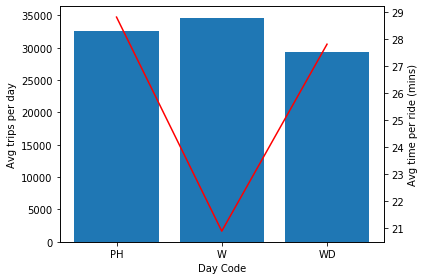

In [40]:
# plotting avg trip data based on type of day
cycle_df_clean['Date'] = cycle_df_clean['Start Date'].dt.date
cycle_df_clean = cycle_df_clean.set_index(['Date', 'Start Date'])
plot_trip_data(cycle_df_clean.groupby('day_code').count().index, 
               cycle_df_clean.groupby(['day_code', 'Date']).count().groupby('day_code').mean()['Duration(mins)'], 
               cycle_df_clean.groupby(['day_code']).mean()['Duration(mins)'], 'Day Code',
               ylabel='Avg trips per day')

<b>Another feature that affects the demand of cycle hires is weather. We can get weather data from a weather API which gives hourly historical data on temperature, wind speed and weather condition from a weather station located in London Southend Airport. We will use the [`requests`](https://pypi.org/project/requests/2.7.0/) package to pull data from the API and extract the useful information into a dataframe.

In [41]:
import requests


def import_weather_from_api(date):
    
    api_url = "https://api.weather.com/v1/location/EGMC:9:GB/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&units=m"
    date_str = '&startDate=' + date + '&endDate=' + date
    
    try:
        response = requests.get(api_url + date_str)
    except requests.exceptions.RequestException as e:
         return "Error: {}".format(e)
    
    weather = []
    for items in response.json()['observations']:
        weather.append((datetime.fromtimestamp(items['valid_time_gmt']), items['temp'], 
                        items['wspd'], items['wx_phrase']))
    
    df = pd.DataFrame(weather, columns=['Time', 'Temperature', 'Wind Speed', 'Conditions'])
    
    return df  

In [42]:
# retrieve weather data for date window determined by cycle hire data
tmp_df = []
for dates in cycle_df_clean.index.get_level_values('Date').unique():
    tmp_df.append(import_weather_from_api(dates.strftime('%Y%m%d')))
                      
weather_df = pd.concat(tmp_df, ignore_index=True).set_index('Time')
weather_df.head()

,Temperature,Wind Speed,Conditions
Time,,,
2019-06-01 00:50:00,13.0,17.0,Fair
2019-06-01 01:50:00,12.0,15.0,Fair
2019-06-01 02:50:00,12.0,11.0,Fair
2019-06-01 03:20:00,12.0,6.0,Fair
2019-06-01 03:50:00,12.0,6.0,Fair


In [43]:
print(weather_df.info())
print(weather_df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3790 entries, 2019-06-01 00:50:00 to 2019-08-27 23:50:00
Data columns (total 3 columns):
Temperature    3789 non-null float64
Wind Speed     3788 non-null float64
Conditions     3790 non-null object
dtypes: float64(2), object(1)
memory usage: 118.4+ KB
None
       Temperature   Wind Speed
count  3789.000000  3788.000000
mean     17.985220    16.126452
std       4.123911    10.010985
min       8.000000     0.000000
25%      15.000000     9.000000
50%      18.000000    15.000000
75%      20.000000    20.000000
max      35.000000   161.000000


<b>We can see from the weather dataframe information and description that there are null values and that the wind speed data could have some outliers. Let's now clean this data!

C:\Users\kc\Anaconda3\envs\Springboard_Projects\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


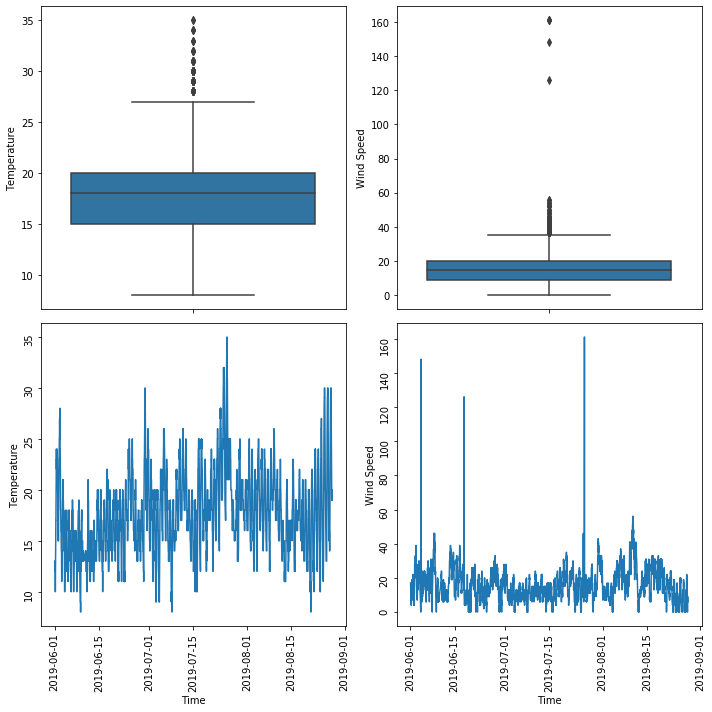

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax1 = sns.boxplot(y=weather_df['Temperature'], ax=ax[0][0])
ax2 = sns.boxplot(y=weather_df['Wind Speed'], ax=ax[0][1])
ax3 = sns.lineplot(x=weather_df.index, y=weather_df['Temperature'], ax=ax[1][0])
ax3.tick_params(labelrotation=90)
ax4 = sns.lineplot(x=weather_df.index, y=weather_df['Wind Speed'], ax=ax[1][1])
ax4.tick_params(labelrotation=90)
fig.tight_layout()
plt.show()

In [45]:
# foward fill na values
weather_df = weather_df.fillna(method='ffill')
if not weather_df.isnull().any().sum():
    print('No more null values')

No more null values


In [46]:
# find outliers in wind speed data by seeing if change in data is large or if value is large
diff = weather_df['Wind Speed'].diff()
print('\033[1m' + 'Wind speed data showing large changes in speed:' + '\033[0m')
print(weather_df[diff > 20]['Wind Speed'])
print('\033[1m' + 'Difference in speed was:' + '\033[0m')
print(diff[diff > 20])
print('\033[1m' + 'Wind speed data with values > 50km/h:' + '\033[0m')
print(weather_df[weather_df['Wind Speed'] > 50])

Wind speed data showing large changes in speed:
Time
2019-06-04 08:50:00    148.0
2019-06-18 00:20:00    126.0
2019-07-26 04:20:00    161.0
Name: Wind Speed, dtype: float64
Difference in speed was:
Time
2019-06-04 08:50:00    139.0
2019-06-18 00:20:00    111.0
2019-07-26 04:20:00    154.0
Name: Wind Speed, dtype: float64
Wind speed data with values > 50km/h:
                     Temperature  Wind Speed               Conditions
Time                                                                 
2019-06-04 08:50:00         16.0       148.0             Fair / Windy
2019-06-18 00:20:00         13.0       126.0             Fair / Windy
2019-07-26 04:20:00         22.0       161.0             Fair / Windy
2019-07-26 04:50:00         22.0       161.0             Fair / Windy
2019-07-26 05:20:00         22.0       161.0             Fair / Windy
2019-08-10 12:20:00         20.0        52.0  Showers in the Vicinity
2019-08-10 13:20:00         21.0        52.0    Mostly Cloudy / Windy
2019-08-1

<b>It is clear that we have 5 data errors in the wind speed data series for the values above 100 km/h. The change in wind speed is too large and wind of that magnitude would have definitely made the news which it didn't. We can fix these data errors using linear interpolation which assumes that the actual value is an average bewteen the prior and post values that are deemed to non erroneous. 

In [47]:
outliers_idx = weather_df[weather_df['Wind Speed'] > 100].index
for i in outliers_idx:
    weather_df.loc[i, 'Wind Speed'] =  np.nan
    
weather_df = weather_df.interpolate()

<b>Now that we have cleaned the data, we can add weather as a feature to our data set. However, before we do this, note that the conditions feature has 27 different categories. Features that are defined categorically with many different categories add significant complexity to the model. We should try and reduce this to a manageable set without losing the information and accuracy of the data.

In [48]:
print('The weather conditions are:')
for i, x in enumerate(weather_df['Conditions'].unique()):
    print(i, x)

The weather conditions are:
0 Fair
1 Fair / Windy
2 Partly Cloudy
3 Rain Shower
4 Light Rain Shower
5 Showers in the Vicinity
6 Light Rain
7 Mostly Cloudy
8 Mostly Cloudy / Windy
9 Light Rain / Windy
10 Partly Cloudy / Windy
11 Light Rain Shower / Windy
12 Rain
13 Thunder in the Vicinity
14 Light Rain with Thunder
15 T-Storm
16 Mist
17 Heavy T-Storm
18 Cloudy
19 Shallow Fog
20 Light Drizzle
21 Thunder
22 Heavy Rain Shower / Windy
23 T-Storm / Windy
24 Patches of Fog
25 Fog
26 Haze


<b>We can reduce it to 4 different categories of weather conditions as such:
<ol type="1">
  <li>Good weather: 0, 1, 2, 10, 16, 18, 19</li>
  <li>OK weather: 4, 5, 7, 8, 11, 13, 20, 24</li>
  <li>Bad weather: 3, 6, 9, 12, 14, 21, 25</li>
  <li>Very bad weather: 15, 17, 22, 23, 26</li>
</ol>


In [49]:
# create dictionary map for weather conditions
map_weather = {}
for i, x in enumerate(weather_df['Conditions'].unique()):
    if i in [0, 1, 2, 10, 16, 18, 19]:
        map_weather[x] = 'Good weather'
    elif i in [4, 5, 7, 8, 11, 13, 20, 24]:
        map_weather[x] = 'OK weather'
    elif i in [3, 6, 9, 12, 14, 21, 25]:
        map_weather[x] = 'Bad weather'
    elif i in [15, 17, 22, 23, 26]:
        map_weather[x] = 'Very bad weather'
    else:
        map_weather[x] = np.nan

weather_df['w_cond'] = weather_df['Conditions'].map(map_weather)
weather_df = weather_df.drop(columns='Conditions')
weather_df.head()

,Temperature,Wind Speed,w_cond
Time,,,
2019-06-01 00:50:00,13.0,17.0,Good weather
2019-06-01 01:50:00,12.0,15.0,Good weather
2019-06-01 02:50:00,12.0,11.0,Good weather
2019-06-01 03:20:00,12.0,6.0,Good weather
2019-06-01 03:50:00,12.0,6.0,Good weather


<b>We can further improve peformance of our model by using one hot encoding on the categorical variable, weather condition. Here, we use the pandas dataframe method [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to encode the weather condition data.

In [50]:
weather_df = pd.get_dummies(weather_df)
weather_df.head()

,Temperature,Wind Speed,w_cond_Bad weather,w_cond_Good weather,w_cond_OK weather,w_cond_Very bad weather
Time,,,,,,
2019-06-01 00:50:00,13.0,17.0,0,1,0,0
2019-06-01 01:50:00,12.0,15.0,0,1,0,0
2019-06-01 02:50:00,12.0,11.0,0,1,0,0
2019-06-01 03:20:00,12.0,6.0,0,1,0,0
2019-06-01 03:50:00,12.0,6.0,0,1,0,0


<b>Now, we can merge the weather data with the cycle trips data. Note that the time index is not the same on both dataframes so we cannot merge them directly. We use the pandas index method [`get_loc(`*`key, method=nearest`*`)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.get_loc.html) to find the weather data in our weather dataframe at the time nearest to the trip start time. 

In [58]:
# find weather data by matching to nearest time 
weather_dict = {}
for date in cycle_df_clean.index.get_level_values('Start Date').unique():
    weather_dict[date] = weather_df.iloc[weather_df.index.get_loc(date, method='nearest')]

# merge new weather dataframe with same index as trip data
df = pd.DataFrame.from_dict(weather_dict, orient='index')
cycle_df_weather = cycle_df_clean.merge(df, left_on='Start Date', right_index=True, how='left')
cycle_df_weather.head()

StartStation Name            End Date  \
Date       Start Date                                                           
2019-06-01 2019-06-01  Westminster University, Marylebone 2019-06-01 00:07:00   
           2019-06-01          Upcerne Road, West Chelsea 2019-06-01 00:01:00   
           2019-06-01          Mile End Stadium, Mile End 2019-06-01 00:19:00   
           2019-06-01      Bethnal Green Road, Shoreditch 2019-06-01 00:10:00   
           2019-06-01          Mile End Stadium, Mile End 2019-06-01 00:19:00   

                                                 EndStation Name  \
Date       Start Date                                              
2019-06-01 2019-06-01  St. John's Wood Church, The Regent's Park   
           2019-06-01                 Upcerne Road, West Chelsea   
           2019-06-01     Mile End Park Leisure Centre, Mile End   
           2019-06-01                 Curlew Street, Shad Thames   
           2019-06-01     Mile End Park Leisure Centre, Mile End   

                       Duration(mins)  Bike Id  StartStation Id  \
Date       Start Date                                             
2019-06-01 2019-06-01             7.0    13485              257   
           2019-06-01             1.0    14376              745   
           2019-06-01            19.0    10693              712   
           2019-06-01            10.0     7390              132   
           2019-06-01            19.0    11332              712   

                       EndStation Id  Day  hour day_code  Temperature  \
Date       Start Date                                                   
2019-06-01 2019-06-01            247    5     0        W         13.0   
           2019-06-01            745    5     0        W         13.0   
           2019-06-01            763    5     0        W         13.0   
           2019-06-01            298    5     0        W         13.0   
           2019-06-01            763    5     0        W         13.0   

                       Wind Speed  w_cond_Bad weather  w_cond_Good weather  \
Date       Start Date                                                        
2019-06-01 2019-06-01        17.0                 0.0                  1.0   
           2019-06-01        17.0                 0.0                  1.0   
           2019-06-01        17.0                 0.0                  1.0   
           2019-06-01        17.0                 0.0                  1.0   
           2019-06-01        17.0                 0.0                  1.0   

                       w_cond_OK weather  w_cond_Very bad weather  
Date       Start Date                                              
2019-06-01 2019-06-01                0.0                      0.0  
           2019-06-01                0.0                      0.0  
           2019-06-01                0.0                      0.0  
           2019-06-01                0.0                      0.0  
           2019-06-01                0.0                      0.0

In [59]:
cycle_df_weather.to_csv('data/cycle_df_weather.csv')
cycle_df_clean.to_csv('data/cycle_df_clean.csv')
weather_df.to_csv('data/weather_df.csv')

<b>We now have a clean data set with added features such as day type, hour of day, temperature, wind speed and weather condition. In the next section of the project, we will look for relationships within our data set using data visualisation tools.